# Module 1: Feature Engineering
## Advanced ML @ SBU (Fall '23)

# Table of Contents:
- [Getting Setup](#getting-set-up)
    - [Load and View Data](#load-and-view-data)
    - [Benchmarking our Feature Engineering](#benchmarking-our-feature-engineering)
- [Filling in Null Values](#filling-in-null-values)
    - [Checking Our Data](#checking-our-data)
    - [Using Scikit-Learn's SimpleImputer](#using-scikit-learns-simpleimputer)
    - [Imputation through Another ML Model](#alternative-strategy-imputation-through-another-ml-model)
- [Encoding Categorical Columns](#encoding-categorical-columns)
    - [One-Hot Encoding](#one-hot-encoding)
    - [Label Encoding](#label-encoding)
    - [Frequency-Based Encoding](#frequency-based-encoding)
    - [Testing: Round 1](#testing-round-1)
        - [Experiment 1: Median vs. Mean Imputation](#experiment-1-median-vs-mean-imputation)
        - [Experiment 2: Removing 0 Values](#experiment-2-removing-0-values)
        - [Experiment 3: Categorical vs. Ordinal vs. Using Frequencies forEncoding](#experiment-3-categorical-vs-ordinal-encoding)
- [Scaling and Normalization](#scaling-and-normalization)
    - [Method 1: Logarithmic Scaling](#method-1-logarithmic-scaling)
    - [Method 2: Mix-Max Scaling](#method-2-min-max-scaling)
    - [Method 3: Z-Score Normalization](#method-3-z-score-normalization)
    - [Experiment 4: Combining different methods](#experiment-4-combining-different-methods)
- [Variable Discretization](#variable-discretization)
    - [Method 1: Equal Length Intervals](#method-1-equal-length-intervals)
    - [Method 2: Equal Frequency Intervals](#method-2-equal-frequency-intervals)
    - [Method 3: K-Means Clustering](#method-3-k-means-clustering)
    - [Experiment 5: Testing What Works Best](#experiment-5-testing-what-works-best)
- [Outlier Detection](#outlier-detection)
    - [Method 1: Box-Plot Method](#method-1-box-plot-method)
    - [Method 2: Z-Score Outlier Detection](#method-2-z-score-outlier-detection)
    - [Method 3: Modified Z-Score Outlier Detection](#method-3-modified-z-score-outlier-detection)
    - [Experiment 6: Outlier Detection](#experiment-6-outlier-detection)
- [Working with Scikit-Learn Pipelines](#working-with-scikit-learn-pipelines)
    - [A Basic Example](#a-basic-example)
    - [Integrating What We've Learned So Far](#integrating-what-weve-learned-so-far)
        - [Column Transformer](#column-transformer)
        - [Function Transformer](#function-transformer)
    - [Adding in Extras](#adding-in-extras)
        - [Feature Selection](#feature-selection)
        - [Feature Interaction and Polynomial Features](#feature-interaction-and-polynomial-features)
        - [Imbalanced Datasets](#imbalanced-datasets)
- [Your Turn](#your-turn)

# Getting Set Up
## Load and View Data 

Here, we'll just do the routine basics; loading relevant libraries and our data.

Same as last week, we'll be using data from the [Spaceship Titanic](#https://www.kaggle.com/competitions/spaceship-titanic/) competition on Kaggle, and using that for today. Just as a reminder, this is a binary classification task, where we're looking to predict the `Transported` column.

In [1]:
# Import libraries (we'll import more libraries further down in the notebook on an as-needed basis)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data & preview our data

raw_df = pd.read_csv('./data/spaceship-titanic.csv')
df = raw_df.copy(deep=True)    # Make a copy, the original will be used more later.
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


For now, we'll drop the columns we won't be immediately using.

> Make *sure* you're using the `df` dataframe, and not the original `raw_df` dataframe, as we'll be making copies of `raw_df` throughout this notebook everytime we want to try out something new

In [3]:
# Drop irrelevant columns

cols_to_drop = ['PassengerId', 'Cabin', 'Name']

df = df.drop(cols_to_drop, axis=1)
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


### Benchmarking our Feature Engineering

Before we get started though, we'll define a function that'll build a classification model (in this case, KNN) that'll take our data as input, train a simple classification model, and evaluate model performance using accuracy, which is given through the formula below:

$$
Accuracy = \frac{correct\_answers}{total\_answers}
$$

(We'll be using [Scikit-Learn's implementation of accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html))

As the focus of this module is feature engineering and not model building, we won't focus on the specifics of the machine learning model, and no feature engineering will be done.


> For the purposes of this notebook, we're using [Scikit-Learn's KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), however, feel free to use any classification model you'd like. KNN was chosen due to being a relatively simple model with no built-in cross validation, while also being sensitive to scaling, outliers, and etc., which will later help illustrate the effect of various feature engineering techniques.

In [4]:
# Function for building a machine learning model

from sklearn.neighbors import KNeighborsClassifier    
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def build_model(X, y):
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=7)
    
    model = KNeighborsClassifier()
    model.fit(train_X, train_y)

    preds = model.predict(test_X)
    return accuracy_score(test_y, preds)

However, as we've learned during the previous module, this won't work until we've done our initial data cleaning.

# Filling in Null Values
## Checking Our Data

Here, we'll focus on various techniques for filling in null values in our dataframe. First, we'll look to see how many null values we have per-column:

In [5]:
# Count null data

df.isna().sum()

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

Last module, we counted how many null values exist for each row, so we'll bring that code over;

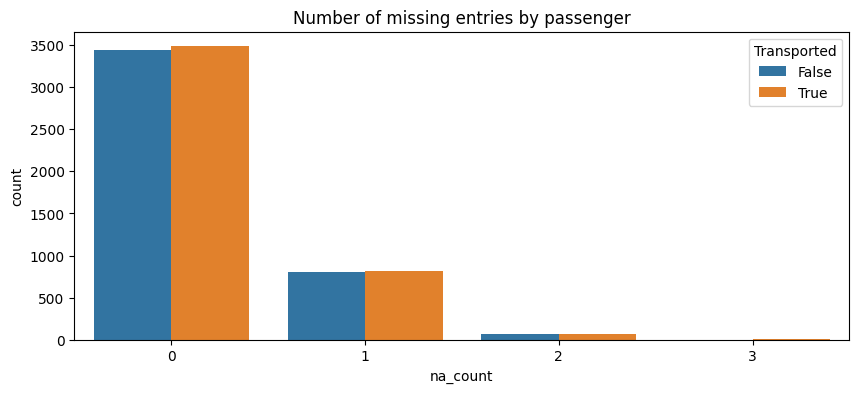

In [6]:
# Countplot of number of missing values by passenger

df['na_count']=df.isna().sum(axis=1)
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='na_count', hue='Transported')
plt.title('Number of missing entries by passenger')
df.drop('na_count', axis=1, inplace=True)

This tells us that even though most columns have null values to a certain extent, the overlap between column-wise null values is very slim; I.E. there aren't very many rows with more than one null value.

Next, we'll explore different methods for filling in said null values.

> For an explanation as to what the various methods are and when we should use various methods for filling in null values, refer to class slides and recodings.

## Using Scikit-Learn's SimpleImputer

For imputation using simple strategies, we can use [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) and specify the strategy.

SimpleImputer's strategies (as per the documentation) are:
- `mean`: Replace missing values using the mean along each column. Can only be used with numeric data.
- `median`: Replace missing values using the median along each column. Can only be used with numeric data.
- `most_frequent`: Replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.
- `constant`: Replace missing values with `fill_value`. Can be used with strings or numeric data.


> Take care that not all methods of imputation works for every column. For instance, as per the documentation, we can't use the `mean` or `median` strategy for categorical columns.

In [7]:
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [8]:
# Example: filling in a numerical column using the median stategy
# For this, we'll be using the Age column for this

from sklearn.impute import SimpleImputer

imputed_df = df.copy(deep=True)    # Making another copy of our dataframe
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

imputer = SimpleImputer(strategy='median')

imputed_df[numerical_cols] = imputer.fit_transform(imputed_df[numerical_cols])

In [10]:
imputed_df[numerical_cols].isna().sum()

Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

We can wrap this into a function, making applying operations on a column-wise basis a bit more clean and flexible:

In [11]:
def impute(data, columns, strategy='median'):
    imputer = SimpleImputer(strategy=strategy)
    data[columns] = imputer.fit_transform(data[columns])
    return data

In [12]:
# Testing the function: 
imputed_df = impute(df.copy(deep=True), numerical_cols)
imputed_df.isna().sum()     # Count the number of na values per column

HomePlanet      201
CryoSleep       217
Destination     182
Age               0
VIP             203
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64

We could repeat this for categorical functions:

In [13]:
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

imputed_df = impute(imputed_df, categorical_cols, strategy='most_frequent')

imputed_df.isna().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

And finally, we can check what our data looks like:

In [14]:
imputed_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


# Encoding Categorical Columns

There are three methods for encoding categorical columns that we'll explore in this notebook:
- One-hot encoding
- Label encoding
- Frequency-based encoding


> For an explanation as to what each of these are and how they work, please refer to the class slides for this module.

Before we get started though, let's quickly convert boolean columns to integers:

In [15]:
cat_df = imputed_df.copy(deep=True)

# While scikit-learn handles a lot of stuff like boolean columns without us having to manually typecast, it's still a 
# good idea to do so.
boolean_columns = ['CryoSleep', 'VIP', 'Transported']
cat_df[boolean_columns] = cat_df[boolean_columns].astype(int)

cat_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0
1,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1
2,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0
3,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0
4,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1


## One-Hot Encoding

While Scikit-Learn does have [an one-hot encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), there's also Pandas' `get_dummies()` function, which we'll be using here. (Documentation [here](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html))

In [16]:
oh_df = cat_df.copy(deep=True)

pd.get_dummies(oh_df['HomePlanet'], dtype=int)

,Earth,Europa,Mars
0,0,1,0
1,1,0,0
2,0,1,0
3,0,1,0
4,1,0,0
...,...,...,...
8688,0,1,0
8689,1,0,0
8690,1,0,0
8691,0,1,0


However, the issue here is that Pandas' `get_dummies()` isn't guaranteed to be consistent on any test sets that we might encounter outside of training (e.g. during deployment).

Therefore, while `pd.get_dummies()` is easier to use, in practice we might opt to use Scikit-Learn's equivalent instead;

In [17]:
from sklearn.preprocessing import OneHotEncoder

oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
oh_encoder.fit(oh_df[['HomePlanet', 'Destination']])

oh_encoder.transform(oh_df[['HomePlanet', 'Destination']])[:10]     # Much like get_dummies(), the result from this function can be concatenated to our original dataframe

array([[0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 0.]])

> However, for the purposes of this demonstration, we'll continue using `get_dummies()` until a bit later on in this notebook.

Similar to when we had imputed missing values, we can wrap this into a function:

In [18]:
def one_hot_encode(data, columns):
    for column in columns:
        oh_col = pd.get_dummies(data[column], dtype=int)
        data = pd.concat([data, oh_col], axis=1)     # Adding new columns 

    data.drop(columns, axis=1, inplace=True)    # Drop the columns we no longer need
    return data

In [19]:
encode_cols = ['Destination', 'HomePlanet']
oh_df = one_hot_encode(oh_df, encode_cols)
oh_df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,55 Cancri e,PSO J318.5-22,TRAPPIST-1e,Earth,Europa,Mars
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,0,0,1,1,0,0
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,0,1,0,1,0
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,0,1,0,1,0
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,0,0,1,1,0,0


## Label Encoding

For this, we'll be using Scikit-Learn's [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder) which is used very similarly to this library's `OneHotEncoder` briefly shown above.

In [20]:
from sklearn.preprocessing import OrdinalEncoder

label_df = cat_df.copy(deep=True)

label_encoder = OrdinalEncoder()
label_encoder.fit(label_df[encode_cols])

label_df[encode_cols] = label_encoder.transform(label_df[encode_cols])
label_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1.0,0,2.0,39.0,0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0,2.0,24.0,0,109.0,9.0,25.0,549.0,44.0,1
2,1.0,0,2.0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0
3,1.0,0,2.0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0
4,0.0,0,2.0,16.0,0,303.0,70.0,151.0,565.0,2.0,1


## Frequency-Based Encoding

For this, we can use Pandas's built-in mapping function. 

Our first step would be to obtain the per-value counts of each column, then map each value in the dataframe to the count of that specific value.

In [21]:
freq_df = cat_df.copy(deep=True)

col_name = 'HomePlanet'
freq = freq_df[col_name].value_counts(normalize=True)
freq_dict = freq.to_dict()

freq_df[col_name] = freq_df[col_name].map(freq_dict)

freq_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0.245140,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0
1,0.552514,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1
2,0.245140,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0
3,0.245140,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0
4,0.552514,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1


We can wrap this in a column for multiple columns:

In [22]:
freq_df = cat_df.copy(deep=True)

def freq_encoding(data, columns):
    for column in columns:
        freq = data[column].value_counts(normalize=True)
        freq_dict = freq.to_dict()

        data[column] = freq_df[column].map(freq_dict)
    return data

freq_df = freq_encoding(freq_df, encode_cols)

freq_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0.245140,0,0.701369,39.0,0,0.0,0.0,0.0,0.0,0.0,0
1,0.552514,0,0.701369,24.0,0,109.0,9.0,25.0,549.0,44.0,1
2,0.245140,0,0.701369,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0
3,0.245140,0,0.701369,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0
4,0.552514,0,0.701369,16.0,0,303.0,70.0,151.0,565.0,2.0,1


## Testing: Round 1

Here, we'll test the efficacy of various methods for feature engineering and data cleaning employed in this notebook so far, and see what works best here.

> It should be noted that just because something works well for this dataset, does not mean that it'll work for another data. An important aspect is experimenting and iterating, over and over.

### Experiment 1: Median vs. Mean Imputation

For this experiment, we'll be retransforming the `df` DataFrame that had very little processing done, beyond dropping irrelevant columns.

For encoding categorical columns, we'll be using one-hot encoding.

In [59]:
df1 = df.copy(deep=True)     # Make a copy of the df dataframe

# Impute categorical columns
df1 = impute(df1, categorical_cols, strategy='most_frequent')
df1 = one_hot_encode(df1, encode_cols)    # One-hot encoding for categorical columns
df1[boolean_columns] = df1[boolean_columns].astype(int)

# Impute numerical cols
df1_median = impute(df1.copy(deep=True), numerical_cols, strategy='median')
df1_mean = impute(df1.copy(deep=True), numerical_cols, strategy='mean')

Now that we've constructed the relevant dataframes, we'll split them into train/test sets and then train our machine learning model.

In [60]:
build_model(df1_median.drop('Transported', axis=1), df1_median['Transported'])

0.7839080459770115

In [61]:
build_model(df1_mean.drop('Transported', axis=1), df1_median['Transported'])

0.7724137931034483

### Experiment 2: Removing 0 Values

For this, we'll use scikit-learn's `SimpleImputer` again, however, while the default value for the `missing_values` argument is `nan`, we can replace that with `0`, and fill those values in.

We'll use the dataframe imputed with the median strategy from the previous experiment.

In [67]:
df_nz = df1_median.copy(deep=True)

nz_imputer = SimpleImputer(missing_values=0)    # Strategy by default is 'mean'

df_nz['Age'] = nz_imputer.fit_transform(df_nz['Age'].values.reshape(-1, 1))

df_nz['Age'].describe()

count    8693.000000
mean       29.392132
std        13.723947
min         1.000000
25%        20.000000
50%        27.000000
75%        37.000000
max        79.000000
Name: Age, dtype: float64

In [69]:
# Build the machine learning model

build_model(df_nz.drop('Transported', axis=1), df_nz['Transported'])

0.7839080459770115

However, an alternative method for this would be to use a machine learning model to impute these `0` values.

> For this, we'll be using Scikit Learn's [RandomForestRegressor](RandomForestRegressor).

In [96]:
from sklearn.ensemble import RandomForestRegressor

# Prep data
df_nz = df1_median.copy(deep=True)   # Make another copy of the data
nz_df = df_nz.drop('Transported', axis=1)
train_nz_df, test_nz_df = df_nz[df_nz['Age'] != 0], df_nz[df_nz['Age'] == 0]

# Train model
nz_model = RandomForestRegressor()
nz_model.fit(train_nz_df.drop('Age', axis=1), train_nz_df['Age'])

# Test model and get predictions
preds = nz_model.predict(test_nz_df.drop('Age', axis=1))
preds[:10]

array([ 9.79801673, 24.23606647, 24.45913271,  9.79801673, 12.64464458,
       13.09591227,  9.79801673,  8.83098636,  7.55384558,  8.83098636])

In [97]:
df_nz.loc[df_nz['Age'] == 0, 'Age'] = preds
df_nz['Age'].describe()

count    8693.000000
mean       29.140144
std        13.871506
min         1.000000
25%        20.000000
50%        27.000000
75%        37.000000
max        79.000000
Name: Age, dtype: float64

In [98]:
build_model(df_nz.drop('Transported', axis=1), df_nz['Transported'])

0.7873563218390804

### Experiment 3: Categorical vs. Ordinal Encoding vs. Frequency Encoding

Thankfully, we no longer need to need to make the data relevant to this experiment, as we've already constructed them during previous steps.

In [103]:
build_model(oh_df.drop('Transported', axis=1), oh_df['Transported'])

0.7839080459770115

In [104]:
build_model(label_df.drop('Transported', axis=1), label_df['Transported'])

0.7850574712643679

In [105]:
build_model(freq_df.drop('Transported', axis=1), freq_df['Transported'])

0.7770114942528735

> It should be noted that the results are relative to *this* dataset, results might be completely different for another dataset. You should take the time to evaluate each dataset you work with in detail so you can make the best possible choices according to your dataset's statistical attributes.

# Scaling and Normalization


> For an explanation on the difference between scaling, normalization and standardization, please refer to class slides.

Before we begin, we'll quickly plot distributions for various numerical columns. The code we'll be using for this was first shown in the previous module;

In [ ]:
# Plot expenditure features
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=df, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    
    # Right plot (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=df, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

## Method 1: Logarithmic Scaling


In [ ]:
# Logarithmic Scaling

## Method 2: Min-Max Scaling

In [ ]:
# MinMaxScaler

## Method 3: Z-Score Normalization

In [ ]:
# StandardScaler

## Experiment 4: Combining different methods

# Variable Discretization
## Method 1: Equal Length Intervals

In [ ]:
# pd.cut

## Method 2: Equal Frequency Intervals

In [ ]:
# pd.qcut

## Method 3: K-Means Clustering

In [ ]:
# KBinsDiscretizer

## Experiment 5: Testing What Works Best

# Outlier Detection


# Method 1: Box-Plot Method

In [ ]:
# df.quantile

## Method 2: Z-Score Outlier Detection

In [ ]:
# Manual

## Method 3: Modified Z-Score Outlier Detection

In [ ]:
# Manual

## Experiment 6: Outlier Detection

# Working With Scikit-Learn Pipelines

Scikit-learn pipelines are a useful tool for streamlining the machine learning workflow. A pipeline is an object that combines multiple steps into a single sequence, allowing for cleaner and more efficient code.

In scikit-learn, a typical machine learning workflow consists of several steps such as data preprocessing, feature extraction, model selection, and model evaluation. These steps can sometimes become cumbersome to handle individually, especially when working with large datasets or complex models.

Pipelines resolve this issue by encapsulating the entire workflow into a single object. Each step in the pipeline is defined as a tuple consisting of a name and an instance of a scikit-learn estimator or transformer. The pipeline then automatically chains these steps together, ensuring that the output of one step is used as the input for the next step.

The benefits of using scikit-learn pipelines are as follows:

1. Simplified workflow: Pipelines make it easier to organize and manage complex workflows by providing a clean and concise way to define and execute multiple steps.

2. Code readability: By eliminating the need for manual data transformation between each step, pipelines improve code readability and maintainability.

3. Automation: Pipelines automate the execution of each step, reducing the chances of errors in the workflow and saving time for repetitive tasks.

4. Preventing data leakage: Pipelines ensure that data transformations or feature extractions are performed separately on the training and test datasets, preventing information from the test dataset to influence the model during training (i.e., data leakage).

In summary, scikit-learn pipelines provide a way to streamline the machine learning workflow, improving code readability, reducing errors, preventing data leakage, and enhancing automation and efficiency.

## Integrating What We've Learned So Far

So, just to recap, the steps we've taken so far to clean our data are the following:

1. Removing null data
2. Encoding categorical columns
3. Additional transforms: Scaling and normalization, variable discretization, outlier detection and removal, ...
4. Building our model


Pipelines are built through "stacking" different transforms on top of each other. In order to do that, we'd create an instance of a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object, and pass these steps on.

In [160]:
from sklearn.pipeline import Pipeline

train_x, test_x, train_y, test_y = train_test_split(df.drop('Transported', axis=1), df['Transported'], test_size=0.1, random_state=7)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder()),
    ('model', KNeighborsClassifier())
])

# Fit pipeline to data
pipeline.fit(train_x, train_y)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder()),
                ('model', KNeighborsClassifier())])

While the code above is incredibly clean, it's also incredibly limited, and we don't have the flexibility we had before.

Thankfully though, we're not out of options, and Scikit Learn has a bunch of ways that we can alter out pipeline to better suit our needs.

### Column Transformer

[ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) is a way of applying different preprocessing steps to different columns of a dataset within a Scikit-learn pipeline. It allows for different transformations to be applied to different subsets of the features in a dataset.

In sklearn pipelines, a ColumnTransformer function is typically used to define a list of transformers, with each transformer specifying a set of columns to transform and the transformation to be applied. It can be used to handle multiple types of data (e.g., numeric and categorical) within the same dataset.

The ColumnTransformer works by creating a transformer object that applies each transformation separately to each set of columns it is defined for. This transformer object can then be included as a step in a Scikit-learn pipeline.

For example, let's say you have a dataset with numeric and categorical columns. You can use a ColumnTransformer to apply different preprocessing steps to these columns. You can define a transformer for the numeric columns that applies a scaler, and another transformer for the categorical columns that applies a one-hot encoding. These transformers can then be included in a pipeline to ensure consistent preprocessing steps are applied to the dataset during training and testing.

We can do that with the imputation for the numerical and categorical columns;

In [167]:
from sklearn.compose import ColumnTransformer


column_imputer = ColumnTransformer(
    transformers = [
        ('numerical', SimpleImputer(strategy='median'), numerical_cols),
        ('categorical', SimpleImputer(strategy='most_frequent'), ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CryoSleep','VIP'])
    ]
)

pipeline = Pipeline([
    ('Imputation', column_imputer),
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ('model', KNeighborsClassifier())
])


pipeline.fit(train_x, train_y)

Pipeline(steps=[('Imputation',
                 ColumnTransformer(transformers=[('numerical',
                                                  SimpleImputer(strategy='median'),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('categorical',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP',
                                                   'CryoSleep', 'VIP'])])),
                ('encoder', OneHotEncoder(handle_unknown='ignore')),
                ('model', KNeighborsClassifier())])

In [169]:
# Evaluate final model

predictions = pipeline.predict(test_x)
accuracy_score(test_y, predictions)

0.6988505747126437

> Something to keep in mind: Pipelines output numpy arrays at every step, so after a specific transformation if we wish to index our data through column names, it's best to get the index of that column, and then pass that on instead. 

We can sidestep this issue somewhat by doing some preprocessing beforehand, and using the pipeline _after_ the data has been preprocessed.


# Your Task For This Class:

Do one of the following:
1. Build a model for [this](http://archive.ics.uci.edu/dataset/2/adult) dataset: http://archive.ics.uci.edu/dataset/2/adult with a reasonable accuracy.
2. Obtain a model accuracy of above 79% for the dataset and what you've learned so far.
- Adding additive features
- Taking the `Cabin` feature in the base dataset into account
- Variable discretization